In [358]:
# from flask import Flask, render_template, request, send_file
from PIL import Image, ImageDraw, ImageOps
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import cv2
import warnings
warnings.filterwarnings("ignore")

In [359]:
image_path = "./images/cat2.png" # Change to Relative Path or some hardcoded path on the repo

In [360]:
image = Image.open(image_path)
size = min(image.size)
image = ImageOps.fit(image, (size, size), Image.ANTIALIAS)
width, height = image.size

# Create a circular mask
mask = Image.new('L', image.size, 0)
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, size, size), fill=255)

# Apply circular mask to the image
circular_image = Image.new('RGB', (width, height))
circular_image.paste(image, mask=mask)

# Save or serve the resulting image
output = BytesIO()
output_path = "./out_images/"+ image_path[9:]
circular_image.save(output, format='PNG')
circular_image.save(output_path, format='PNG')

In [361]:
def image_cleanup(img):
    # Maybe Do: Make the contrast more contrasty
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # Scale the image to 400x400 pixels
    scaled_image = cv2.resize(blurred_image, (400, 400))
    reversed_image = cv2.bitwise_not(scaled_image)
    return reversed_image

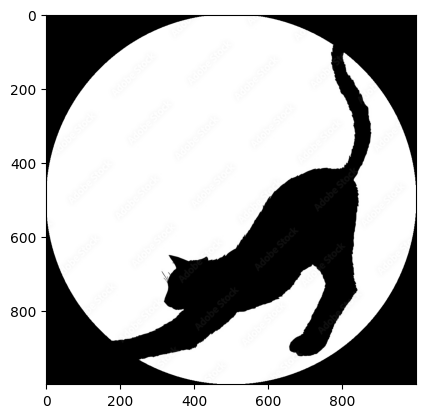

In [362]:
img = cv2.imread(output_path)
plt.imshow(img)

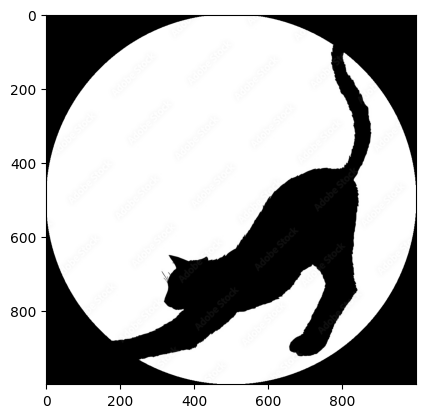

In [363]:
img2 = img[:,:,::-1]
plt.imshow(img2)

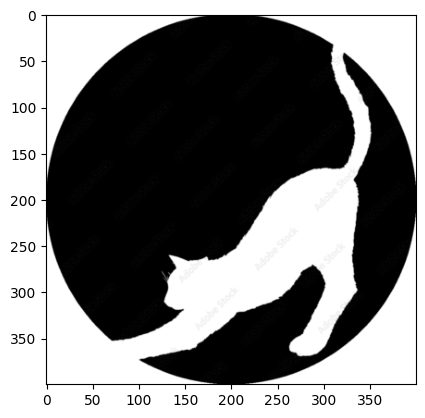

In [364]:
img3 = image_cleanup(img2)
plt.imshow(img3,'gray')

In [365]:
def edge_points(img, n):
    points = []
    height, width = img.shape
    # Define circle parameters (adjust these based on your image size)
    center_x = width // 2
    center_y = height // 2
    radius = min(center_x, center_y) - 1  # Ensure the circle is within the image bounds

    # Sample points along the circumference
    theta = np.linspace(0, 2 * np.pi, n)
    edge_points_x = np.uint16(center_x + radius * np.cos(theta))
    edge_points_y = np.uint16(center_y + radius * np.sin(theta))
    edge_points_x = edge_points_x.astype(np.int64)
    edge_points_y = edge_points_y.astype(np.int64)
    return edge_points_x, edge_points_y

def draw_lines(edge_x, edge_y):
    for i in range(0,100):
        for j in range(i,100):
            xs = [edge_x[i],edge_x[j]]
            ys = [edge_y[i],edge_y[j]]
            plt.plot(xs, ys,color='black',lw = 0.1)

edge_x, edge_y = edge_points(img3, 100)
# plt.figure(figsize=(5,5))
# plt.plot(edge_x, edge_y,'o')
# draw_lines(edge_x, edge_y)

In [366]:
def bresenham(x1, y1, x2, y2, swap=False, neg_y=False):
    if y2 < y1 and not neg_y:
        return bresenham(x1, y1, x2, y2, swap=swap, neg_y=True)
    if x2 < x1:
        return bresenham(x2, y2, x1, y1, swap=swap)[::-1]
    line = []
    x = x1
    y = y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    if dy > dx:
        return bresenham(y1, x1, y2, x2, swap=True)
    P = 2 * dy - dx
    while x <= x2:
        if swap:
            line.append((y, x))
        else:
            line.append((x, y))
        x += 1
        if P < 0:
            P = P + 2 * dy
        else:
            P = P + 2 * dy - 2 * dx
            if neg_y:
                y -= 1
            else:
                y += 1
    return line

# bresenham(29,97,196,1)

In [367]:
def create_database(edge_x,edge_y):
    line_dict = dict()
    for i in range(0,100): # for every edge point
        for j in range(i+1,100): # go to all the others, 
            # Calculate intermediate points with bresenham
            points = [(edge_x[i],edge_y[i]), (edge_x[j],edge_y[j])] 
            points.sort(key=lambda x: x[0])
            x1 = points[0][0]
            y1 = points[0][1]
            x2 = points[1][0]
            y2 = points[1][1]
            line_dict[f"{x1},{y1} {x2},{y2}"] = bresenham(x1,y1,x2,y2) # Add to dictionary
    return line_dict

line_dict = create_database(edge_x,edge_y)
# line_dict['29,97 196,1']

In [375]:
def error(img,canvas):
    return sum(sum(abs(img-canvas)))

def try_line(points,current_canvas,img):
    temp_canvas = current_canvas.copy()
    for x,y in points:
        temp_canvas[x,y] += 51
    return error(img,temp_canvas), temp_canvas

In [369]:
import random

def pick_next_point(start,current_canvas, img, line_dict):
    filtered_dict = {key:value for key, value in line_dict.items() if start in key}
    best_line = random.choice(list(filtered_dict.keys())) # initialise to random edge point
    best_error = try_line(filtered_dict[best_line],current_canvas,img)[0]
    
    for key, value in filtered_dict.items():
        current_error, temp_canvas = try_line(value,current_canvas,img)
        if current_error < best_error:
            best_error = current_error
            best_line = key
            current_canvas = temp_canvas
    for end_point in best_line.split():
        if end_point != start:
            point = end_point
    return point, current_canvas

In [376]:
def sim(n, img):
    start = "395,162"
    xs = [395]
    ys = [162]
    current_canvas = np.zeros_like(img)
    for i in range(n):
        point, new_canvas = pick_next_point(start, current_canvas, img, line_dict)
        start = point
        x, y = point.split(',')
        xs.append(int(x))
        ys.append(int(y))
        current_canvas = new_canvas
    return current_canvas, xs,ys

In [377]:
finished_canvas, xs,ys = sim(200, np.array(img3))
#plt.figure(figsize=(7,7))
# edge_x, edge_y = edge_points(img3, 100)
# plt.plot(edge_x, edge_y,'.',alpha = 0.2)
# plt.plot(xs,ys,alpha = 0.5,color='black')

In [372]:
# print(list(zip(xs,ys)))

[(395, 162), (397, 174), (3, 168), (389, 262), (36, 87), (392, 150), (51, 67), (171, 3), (293, 24), (315, 37), (325, 45), (1, 206), (397, 174), (23, 108), (379, 114), (17, 279), (379, 114), (29, 97), (379, 114), (23, 108), (379, 114), (29, 302), (389, 137), (3, 168), (389, 137), (9, 143), (389, 137), (36, 312), (209, 398), (100, 372), (134, 388), (79, 358), (315, 362), (1, 206), (398, 187), (1, 181), (397, 174), (398, 212), (5, 243), (397, 225), (1, 218), (397, 225), (398, 212), (399, 200), (1, 218), (399, 200), (29, 302), (399, 200), (1, 218), (384, 126), (398, 212), (399, 200), (1, 218), (384, 126), (9, 143), (398, 212), (9, 143), (398, 212), (1, 193), (399, 199), (79, 41), (399, 200), (79, 41), (399, 199), (79, 41), (146, 8), (344, 62), (360, 82), (367, 92), (1, 193), (399, 199), (399, 200), (398, 187), (1, 193), (399, 199), (399, 200), (399, 199), (399, 200), (399, 199), (399, 200), (399, 199), (399, 200), (399, 199), (399, 200), (399, 199), (399, 200), (399, 199), (79, 358), (146,

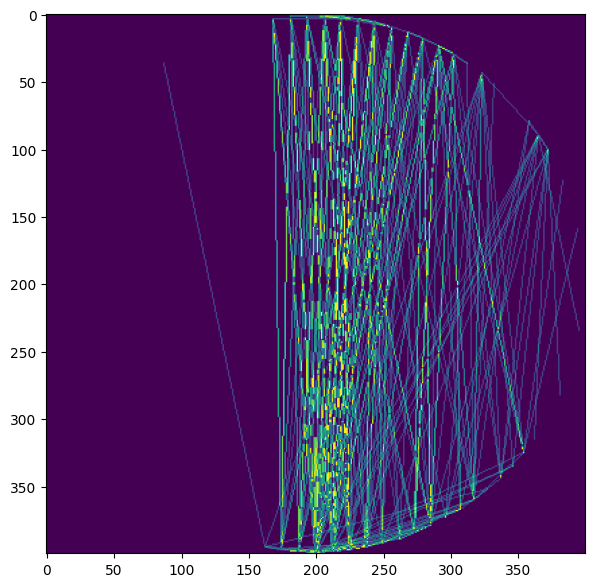

In [378]:
plt.figure(figsize=(7,7))
plt.imshow(finished_canvas)

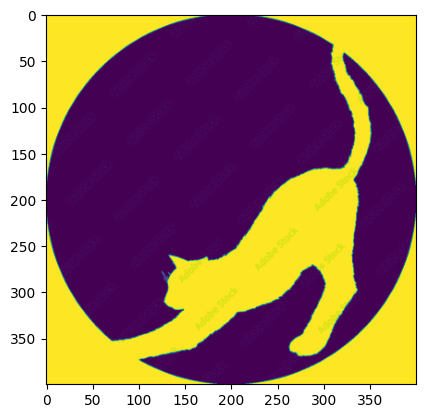

In [379]:
plt.imshow(img3)